From the previouse notebook, it was observed that adding the seasonality component made us unable to train the model as it took very long. 

Now, we'll remove the seasonality component completely. and add new features for date, day, month, etc along with other exogenous variables

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 5)
# from statsmodels.tsa.stattools import adfuller
# import statsmodels.api as sm
from datetime import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox

# from statsmodels.graphics.gofplots import qqplot


from tqdm.notebook import tqdm
from itertools import product
from typing import Union
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Ingest

In [2]:
from functions import get_prepared_data

In [3]:
weather_train = get_prepared_data(set='train')
weather_test = get_prepared_data(set='test')

In [4]:
weather_train.shape, weather_test.shape

((1461, 10), (114, 10))

In [5]:
weather_train.head()

,meantemp,humidity,wind_speed,meanpressure,year,month,day_of_month,weekday,quarter,day_of_year
date,,,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,1,1,1,1,1
2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,1,2,2,1,2
2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,1,3,3,1,3
2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,1,4,4,1,4
2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,1,5,5,1,5


In [6]:
weather_test.head()

,meantemp,humidity,wind_speed,meanpressure,year,month,day_of_month,weekday,quarter,day_of_year
date,,,,,,,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000,2017,1,1,6,1,1
2017-01-02,18.500000,77.222222,2.894444,1018.277778,2017,1,2,0,1,2
2017-01-03,17.111111,81.888889,4.016667,1018.333333,2017,1,3,1,1,3
2017-01-04,18.700000,70.050000,4.545000,1015.700000,2017,1,4,2,1,4
2017-01-05,18.388889,74.944444,3.300000,1014.333333,2017,1,5,3,1,5


`d=1` as tested before

## Train test

In [7]:
# exogenous and endogenous variable for the training dataset
target_train = weather_train["meantemp"]
exog_train = weather_train.drop(columns=['meantemp'])

In [8]:
target_train.head()

date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
Freq: D, Name: meantemp, dtype: float64

In [9]:
exog_train.head()

,humidity,wind_speed,meanpressure,year,month,day_of_month,weekday,quarter,day_of_year
date,,,,,,,,,
2013-01-01,84.500000,0.000000,1015.666667,2013,1,1,1,1,1
2013-01-02,92.000000,2.980000,1017.800000,2013,1,2,2,1,2
2013-01-03,87.000000,4.633333,1018.666667,2013,1,3,3,1,3
2013-01-04,71.333333,1.233333,1017.166667,2013,1,4,4,1,4
2013-01-05,86.833333,3.700000,1016.500000,2013,1,5,5,1,5


## ARIMAX

train with differen parameters for p and q. Get the model with the lowest AIC

In [10]:
def optimize_ARIMAX(endog: Union[pd.Series, list], 
                     exog: Union[pd.Series, list], 
                     order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [11]:
p = range(0, 5, 1)
d = 1
q = range(0, 5, 1)

In [12]:
parameters = product(p, q)
parameters_list = list(parameters)
len(parameters_list)

25

In [13]:
# # Get the model with the lowest AIC
# %time result = optimize_ARIMAX(target_train, exog_train, parameters_list, d)
# result

The model with the lowest AIC value has p,q = 0, 3

In [14]:
best_model = SARIMAX(target_train, exog_train, order=(0,1,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

In [15]:
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1461
Model:               SARIMAX(0, 1, 4)   Log Likelihood               -2341.890
Date:                Mon, 01 Apr 2024   AIC                           4711.780
Time:                        05:50:29   BIC                           4785.787
Sample:                    01-01-2013   HQIC                          4739.388
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
humidity        -0.1401      0.003    -41.078      0.000      -0.147      -0.133
wind_speed      -0.0287      0.006     -4.500      0.000      -0.041      -0.016
meanpressure -3.166e-05      0.001     -0.06

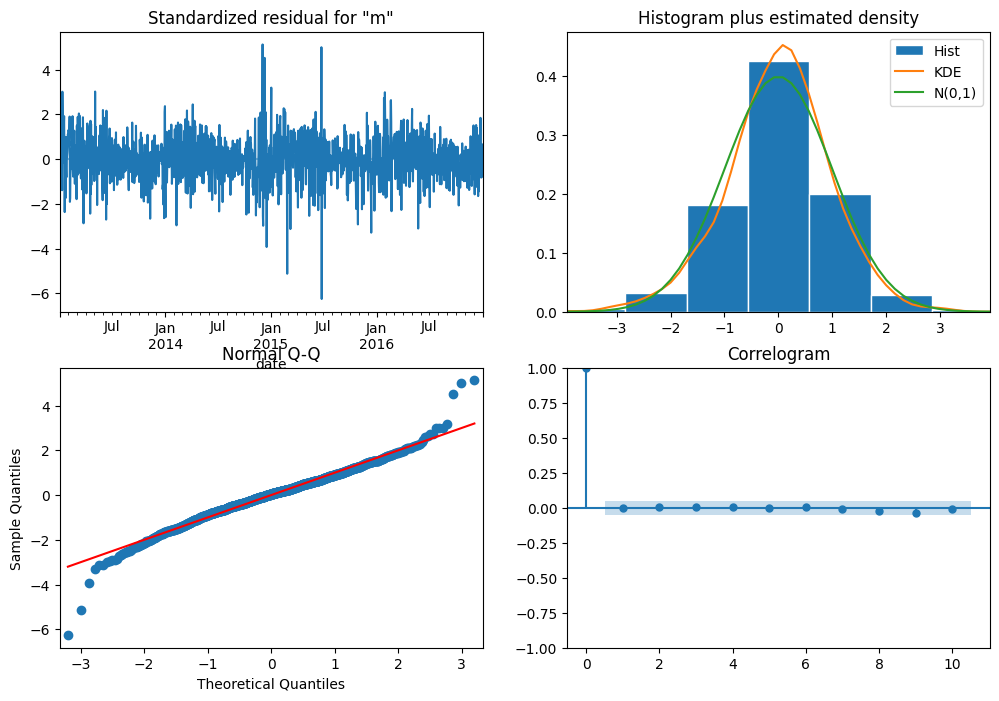

In [16]:
# Perform residual analysis
best_model_fit.plot_diagnostics(figsize=(12,8), );

Theres no discernable pattern in the top left plot of residuals. This is good

The distribution of the residuals at the top right is very close to a normal distribution.

The QQ plot is fairly sstraight although it tapers off at both ends.

The correlogram shows the correlation of residuals at differnt lags. There is no significant coefficient after lag 0.

**Thus, from a qualitative standpoint, it seems that our residuals are fairly close to white noise. We might need to train with more parameters**

Let us evaluate the residuals from a qualitative standpoint. 
Use the Ljung-Box test to determine if the residuals are correlated. 

If all p-values are greater than 0.05, we cannot reject the null hypothesis and we’ll conclude that the residuals are not correlated, just like white noise.

In [17]:
residuals = best_model_fit.resid

acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.000314,0.985863
2,0.000433,0.999783
3,0.000583,0.999996
4,0.000689,1.000000
5,0.000689,1.000000
6,0.000797,1.000000
7,0.000829,1.000000
8,0.002474,1.000000
9,0.002868,1.000000
10,0.004824,1.000000


The Ljunt-Box test gives us confidence that our errors are random

## Forecasting the test set

In [18]:
weather_test.head()

,meantemp,humidity,wind_speed,meanpressure,year,month,day_of_month,weekday,quarter,day_of_year
date,,,,,,,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000,2017,1,1,6,1,1
2017-01-02,18.500000,77.222222,2.894444,1018.277778,2017,1,2,0,1,2
2017-01-03,17.111111,81.888889,4.016667,1018.333333,2017,1,3,1,1,3
2017-01-04,18.700000,70.050000,4.545000,1015.700000,2017,1,4,2,1,4
2017-01-05,18.388889,74.944444,3.300000,1014.333333,2017,1,5,3,1,5


In [19]:
# exogenous and endogenous variable for the training dataset
target_test = weather_test["meantemp"]
exog_test = weather_test.drop(columns=['meantemp'])

In [20]:
# target_test.head()
# exog_test.head()

In [21]:
target_test.shape, exog_test.shape

((114,), (114, 9))

In [22]:
# Copy the test dataset. This is wehere we'ss tore all the predicted values from our various models
pred_df = target_test.to_frame().copy()
pred_df.head()

,meantemp
date,
2017-01-01,15.913043
2017-01-02,18.500000
2017-01-03,17.111111
2017-01-04,18.700000
2017-01-05,18.388889


+ Baseline1: Predict all values afor the first 114 days from Last year
+ Model1: Use the ARIMAX to predict the entire test set in one go

+ Baseline: Predict all values from last 7 days
+ Model2: Perform rolling forecast and predict 7 days at a time

+ Baseline3: Predict yesterday's value
+ Model3. Perform rolling forecast and predict 1 day at a time

Baseline 1: Predict all values for the first 114 days from Last year

In [23]:
pred_df.loc[:, "lastyear"] = target_train.loc["2016-01-01":"2016-04-23"].values
pred_df.head()

,meantemp,lastyear
date,,
2017-01-01,15.913043,14.714286
2017-01-02,18.500000,14.000000
2017-01-03,17.111111,14.375000
2017-01-04,18.700000,15.750000
2017-01-05,18.388889,15.833333


Model_1. Train and predict all values in one Go

In [24]:
%time model = SARIMAX(target_train, exog_train, order=(0,1,4), simple_differencing=False)
model_fit = model.fit(disp=False)

CPU times: user 17.4 ms, sys: 9.2 ms, total: 26.6 ms
Wall time: 13.2 ms


In [25]:
sarima_preds = best_model_fit.get_prediction('2017-01-01', '2017-04-24', exog=exog_test).predicted_mean
sarima_preds[:5]

2017-01-01    16.343869
2017-01-02    17.574585
2017-01-03    16.805317
2017-01-04    18.411678
2017-01-05    17.762768
Freq: D, Name: predicted_mean, dtype: float64

In [26]:
pred_df.loc[:, "arimax_all"] = sarima_preds
pred_df.head()

,meantemp,lastyear,arimax_all
date,,,
2017-01-01,15.913043,14.714286,16.343869
2017-01-02,18.500000,14.000000,17.574585
2017-01-03,17.111111,14.375000,16.805317
2017-01-04,18.700000,15.750000,18.411678
2017-01-05,18.388889,15.833333,17.762768


The following require a recursive forecast

+ Baseline2: Use values from last 7 days
+ Model2: Perform rolling forecast and predict 7 days at a time

+ Baseline3: Predict yesterday's value
+ Model3. Perform rolling forecast and predict 1 day at a time

Join the train and test data. To make this easier

In [27]:
weather_train.shape, weather_test.shape

((1461, 10), (114, 10))

In [28]:
weather = pd.concat([weather_train, weather_test], axis=0)
weather.shape

(1575, 10)

In [30]:
# endogenous and exogenous variable
target = weather["meantemp"]
exog = weather.drop(columns=['meantemp'])

In [31]:
target_train = target[:1461]
target_test = target[1461:]

In [32]:
len(target_train), len(target_test)

(1461, 114)

In [33]:
# Function for recursive forecast
def recursive_forecast(endog: Union[pd.Series, list], 
                       exog: Union[pd.Series, list], 
                       train_len: int, 
                       horizon: int, 
                       window: int, 
                       method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last_x_values':
        pred_last_x_values = []
        
        for i in range(train_len, total_len, window):
            last_x_values = endog[i-window:i].values
            pred_last_x_values.extend(last_x_values)
            
        return pred_last_x_values
    
    elif method == 'ARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(0,1,3), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [34]:
TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW_1 = 1
WINDOW_7 = 7

TRAIN_LEN, HORIZON

(1461, 114)

Predict values from last 7 days

In [35]:
%time pred_last7days = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW_7, 'last_x_values')

CPU times: user 1 ms, sys: 1.12 ms, total: 2.13 ms
Wall time: 2.07 ms


In [36]:
len(pred_last7days), pred_last7days[:5]

(119,
 [14.0, 17.142857142857142, 16.85, 17.217391304347824, 15.238095238095235])

In [37]:
# Add it to pred_df
pred_df["last7days"] = pred_last7days[:114]
pred_df.head()

,meantemp,lastyear,arimax_all,last7days
date,,,,
2017-01-01,15.913043,14.714286,16.343869,14.000000
2017-01-02,18.500000,14.000000,17.574585,17.142857
2017-01-03,17.111111,14.375000,16.805317,16.850000
2017-01-04,18.700000,15.750000,18.411678,17.217391
2017-01-05,18.388889,15.833333,17.762768,15.238095


Predict 7 days at a time

In [38]:
%time pred_arimax_7 = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW_7, 'ARIMAX')

CPU times: user 5min 24s, sys: 6min 32s, total: 11min 57s
Wall time: 3min 30s


In [39]:
len(pred_arimax_7), pred_arimax_7[:5]

(119,
 [14.86631232932541,
  16.341630734337286,
  17.84355277925988,
  17.01184597480733,
  14.393517925041579])

In [40]:
pred_df["arimax_7"] = pred_arimax_7[:114]
pred_df.head()

,meantemp,lastyear,arimax_all,last7days,arimax_7
date,,,,,
2017-01-01,15.913043,14.714286,16.343869,14.000000,14.866312
2017-01-02,18.500000,14.000000,17.574585,17.142857,16.341631
2017-01-03,17.111111,14.375000,16.805317,16.850000,17.843553
2017-01-04,18.700000,15.750000,18.411678,17.217391,17.011846
2017-01-05,18.388889,15.833333,17.762768,15.238095,14.393518


predict values from yesterday i.e last 1 day

In [41]:
# Predict last value
%time pred_yesterday = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW_1, 'last_x_values')

CPU times: user 5.9 ms, sys: 0 ns, total: 5.9 ms
Wall time: 5.95 ms


In [43]:
len(pred_yesterday), pred_yesterday[:5]

(114, [15.052631578947368, 15.91304347826087, 18.5, 17.11111111111111, 18.7])

In [44]:
# Add it to pred_df
pred_df["yesterday"] = pred_yesterday
pred_df.head()

,meantemp,lastyear,arimax_all,last7days,arimax_7,yesterday
date,,,,,,
2017-01-01,15.913043,14.714286,16.343869,14.000000,14.866312,15.052632
2017-01-02,18.500000,14.000000,17.574585,17.142857,16.341631,15.913043
2017-01-03,17.111111,14.375000,16.805317,16.850000,17.843553,18.500000
2017-01-04,18.700000,15.750000,18.411678,17.217391,17.011846,17.111111
2017-01-05,18.388889,15.833333,17.762768,15.238095,14.393518,18.700000


Predict one day at a time

In [45]:
%time pred_arimax_1 = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW_1, 'ARIMAX')

CPU times: user 36min 49s, sys: 44min 13s, total: 1h 21min 2s
Wall time: 23min 21s


In [46]:
len(pred_arimax_1), pred_arimax_1[:5]

(114,
 [14.31563070677521,
  16.266142885583122,
  17.241133480573808,
  17.634900934791858,
  18.632119963505374])

In [51]:
pred_df["arimax_1"] = pred_arimax_1
pred_df.head()

,meantemp,lastyear,arimax_all,last7days,arimax_7,yesterday,arimax_1
date,,,,,,,
2017-01-01,15.913043,14.714286,16.343869,14.000000,14.866312,15.052632,14.315631
2017-01-02,18.500000,14.000000,17.574585,17.142857,16.341631,15.913043,16.266143
2017-01-03,17.111111,14.375000,16.805317,16.850000,17.843553,18.500000,17.241133
2017-01-04,18.700000,15.750000,18.411678,17.217391,17.011846,17.111111,17.634901
2017-01-05,18.388889,15.833333,17.762768,15.238095,14.393518,18.700000,18.632120


In [59]:
pred_df.tail()

,meantemp,lastyear,arimax_all,last7days,arimax_7,yesterday,arimax_1
date,,,,,,,
2017-04-20,34.500,34.000000,24.719688,29.666667,28.889566,33.500,33.732859
2017-04-21,34.250,34.062500,23.017150,30.500000,28.267475,34.500,32.560929
2017-04-22,32.900,34.000000,22.749033,31.222222,30.951032,34.250,32.720113
2017-04-23,32.875,33.250000,24.595806,31.000000,30.220665,32.900,33.597813
2017-04-24,32.000,31.916667,24.622012,32.555556,29.845209,32.875,34.093059


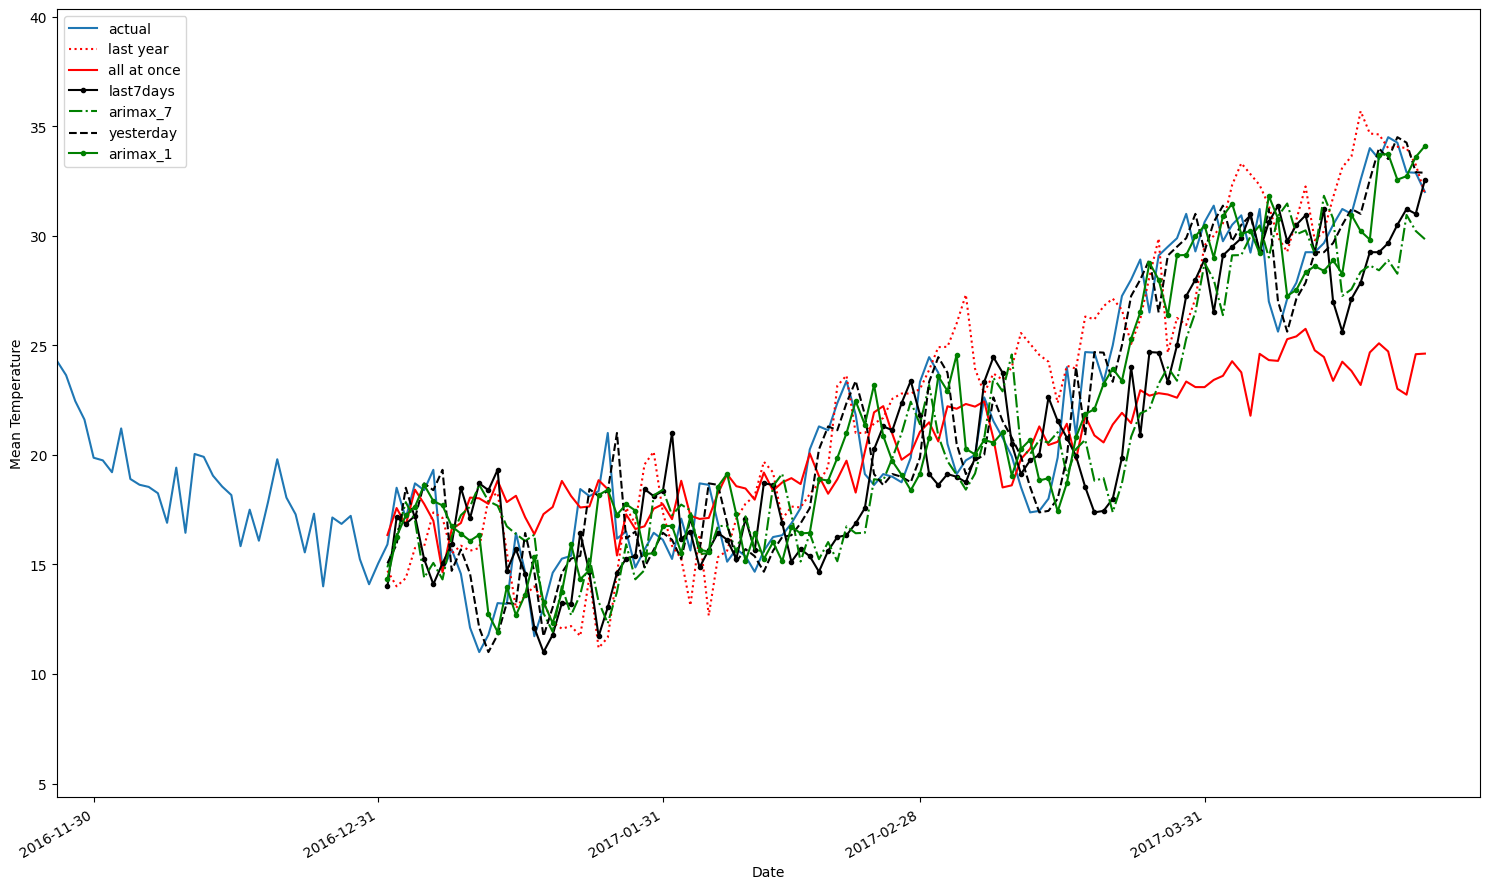

In [52]:
# Visualize the predictions
fig, ax = plt.subplots(figsize=(15,9))

ax.plot(weather.meantemp, label='actual')
ax.plot(pred_df.lastyear, 'r:', label='last year')
ax.plot(pred_df.arimax_all, 'r-', label='all at once')
ax.plot(pred_df.last7days, 'k.-', label='last7days')
ax.plot(pred_df.arimax_7, 'g-.', label='arimax_7')
ax.plot(pred_df.yesterday, 'k--', label='yesterday')
ax.plot(pred_df.arimax_1, 'g.-', label='arimax_1')

ax.set_xlabel('Date')
ax.set_ylabel('Mean Temperature')
# ax.axvspan(xmin='2005-07-01', xmax='2008-06-01', color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(pd.date_range(start=weather.index.min(), end=weather.index.max(), freq='M'))

ax.set_xlim(xmin=datetime(2016, 11, 26), xmax=datetime(2017, 4, 30))

fig.autofmt_xdate()
plt.tight_layout()

In [53]:
mae_lastyear = mean_absolute_error(pred_df.meantemp, pred_df.lastyear)
mae_all_at_once = mean_absolute_error(pred_df.meantemp, pred_df.arimax_all)

mae_last7days = mean_absolute_error(pred_df.meantemp, pred_df.last7days)
mae_arimax_7 = mean_absolute_error(pred_df.meantemp, pred_df.arimax_7)

mae_yesterday = mean_absolute_error(pred_df.meantemp, pred_df.yesterday)
mae_arimax_1 = mean_absolute_error(pred_df.meantemp, pred_df.arimax_1)

In [54]:
mae_lastyear, mae_all_at_once, mae_last7days, mae_arimax_7, mae_yesterday, mae_arimax_1

(2.616887072354993,
 3.543478651425518,
 2.977510113533273,
 2.959900739318693,
 1.3136235062381887,
 1.7782086888606388)

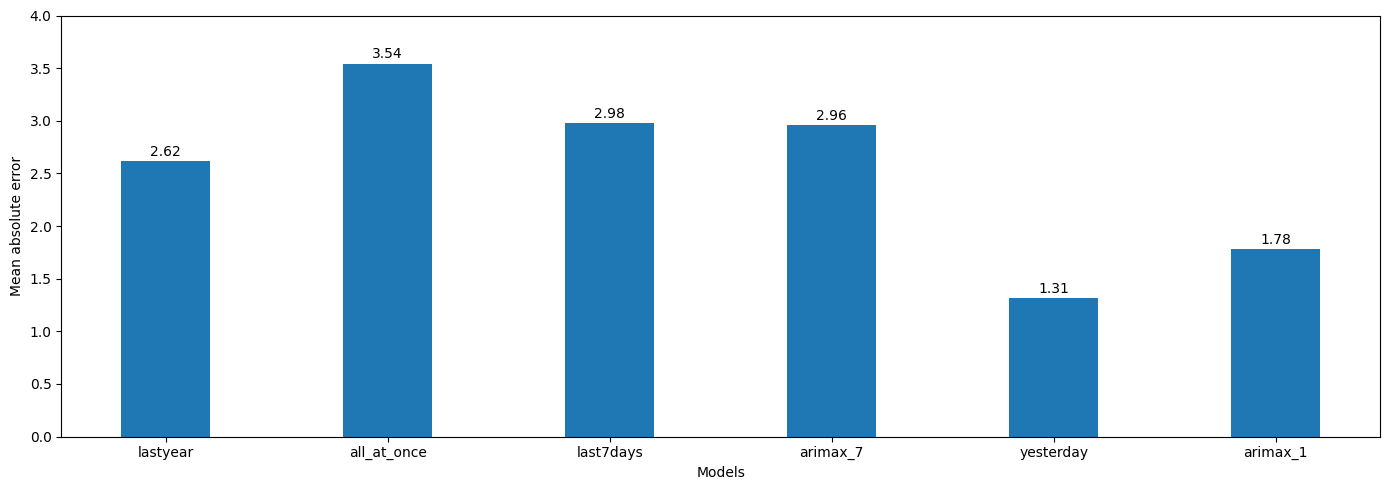

In [57]:
# Visualize
fig, ax = plt.subplots()

x = ['lastyear', 'all_at_once', 'last7days', 'arimax_7', 'yesterday', 'arimax_1']
y = [mae_lastyear, mae_all_at_once, mae_last7days, mae_arimax_7, mae_yesterday, mae_arimax_1]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('Mean absolute error')
ax.set_ylim(0, 4)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

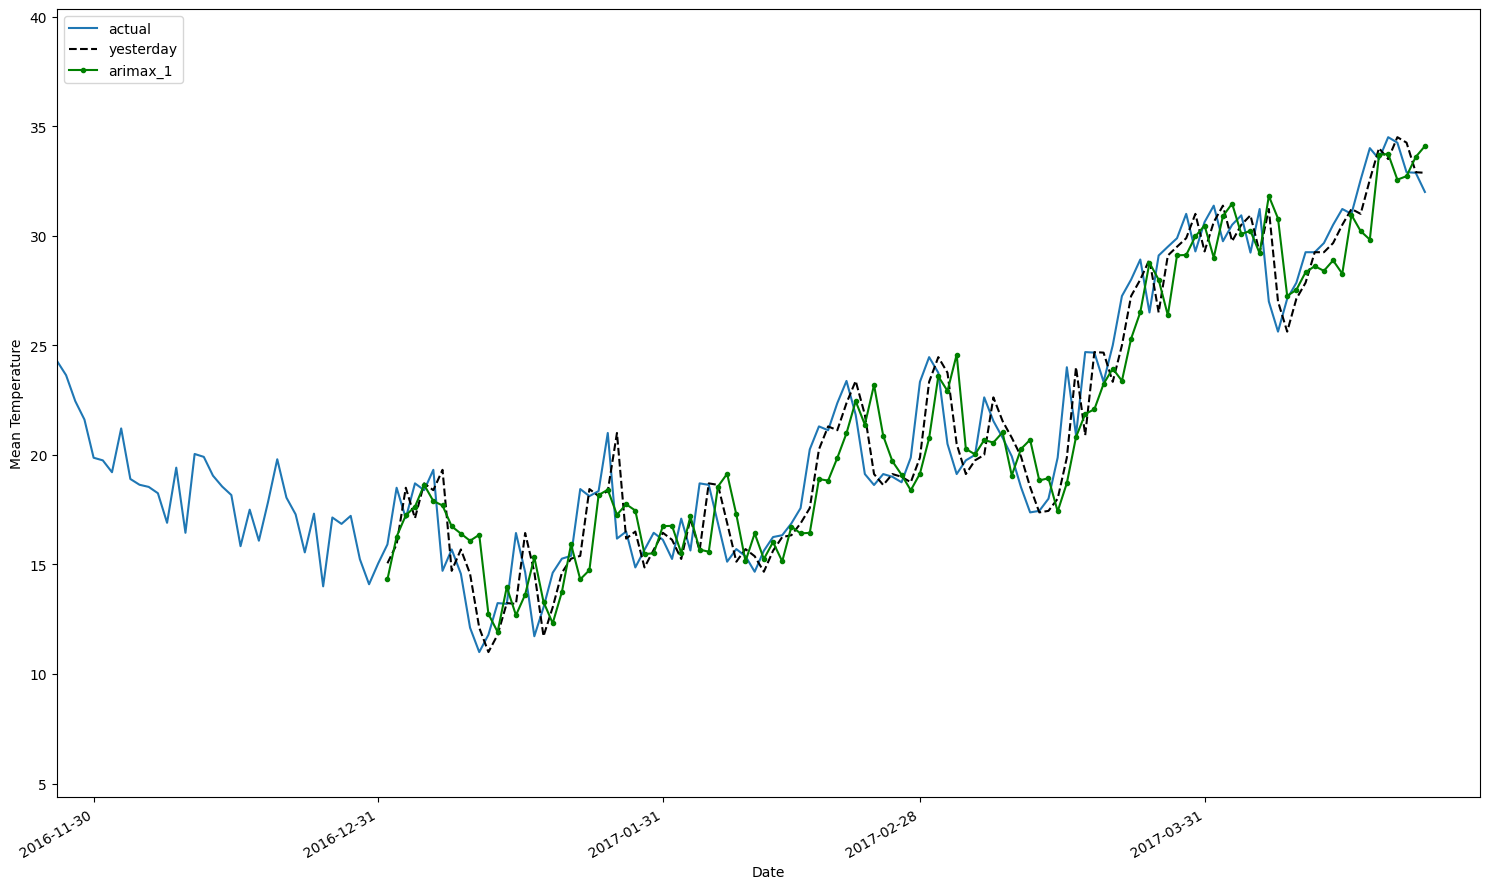

In [58]:
# Visualize the predictions
fig, ax = plt.subplots(figsize=(15,9))

ax.plot(weather.meantemp, label='actual')
# ax.plot(pred_df.lastyear, 'r:', label='last year')
# ax.plot(pred_df.arimax_all, 'r-', label='all at once')
# ax.plot(pred_df.last7days, 'k.-', label='last7days')
# ax.plot(pred_df.arimax_7, 'g-.', label='arimax_7')
ax.plot(pred_df.yesterday, 'k--', label='yesterday')
ax.plot(pred_df.arimax_1, 'g.-', label='arimax_1')

ax.set_xlabel('Date')
ax.set_ylabel('Mean Temperature')
# ax.axvspan(xmin='2005-07-01', xmax='2008-06-01', color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(pd.date_range(start=weather.index.min(), end=weather.index.max(), freq='M'))

ax.set_xlim(xmin=datetime(2016, 11, 26), xmax=datetime(2017, 4, 30))

fig.autofmt_xdate()
plt.tight_layout()

Predicting yesterday's temperature is the best. 
As it turns out, yesterdays temperature is very predictive of today's temperature

But due to the transition of seasons. It is best to use the predictions from ARIMAX model as it seems to anticipate change in seasons better